In [2]:
#20 min of video playback (max brightness) then standby mode, then video, standby 

In [3]:
import sys
import logging
from uuid import UUID

import arrow
import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import public_data

logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)

android_id = "248d8da2-9288-41b2-a0fe-29c1f2f01932"

In [4]:
# pull data from the server (going to take a few minutes)
server_url = 'https://e-mission.eecs.berkeley.edu'

start_ts = arrow.get('2016-10-10 23:35:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts = arrow.get('2016-10-11 00:57:00', 'YYYY-MM-DD HH:mm:ss').timestamp

phone_ids = [android_id]

public_data.request_batched_data(server_url, start_ts, end_ts, phone_ids)

Data loaded to local server!


In [5]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
android_ts = esta.TimeSeries.get_time_series(UUID(android_id))

#time query specification
#overall 
start_ts = arrow.get('2016-10-10 23:35:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts = arrow.get('2016-10-11 00:57:00', 'YYYY-MM-DD HH:mm:ss').timestamp

time_range = estt.TimeQuery("metadata.write_ts", start_ts, end_ts)
android_battery_df = android_ts.get_data_df("background/battery", time_range)


# 20min video 
start_ts0 = arrow.get('2016-10-10 23:35:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts0 = arrow.get('2016-10-10 23:55:00', 'YYYY-MM-DD HH:mm:ss').timestamp

# 20min standby
start_ts1 = arrow.get('2016-10-10 23:55:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts1 = arrow.get('2016-10-11 00:15:00', 'YYYY-MM-DD HH:mm:ss').timestamp

# 20min video 
start_ts2 = arrow.get('2016-10-11 00:15:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts2 = arrow.get('2016-10-11 00:35:00', 'YYYY-MM-DD HH:mm:ss').timestamp

# 30min standby
start_ts3 = arrow.get('2016-10-11 00:35:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts3 = arrow.get('2016-10-11 00:57:00', 'YYYY-MM-DD HH:mm:ss').timestamp

time_list = [(start_ts0, end_ts0), (start_ts1, end_ts1), (start_ts2, end_ts2), (start_ts3, end_ts3)]
time_range_list = map(lambda t: estt.TimeQuery("metadata.write_ts", t[0], t[1]), time_list)
android_battery_df_list = map(lambda t: android_ts.get_data_df("background/battery", t), time_range_list)

In [6]:
android_test = android_battery_df_list[0]
#android_test[['fmt_time', 'battery_level_pct', 'battery_status']]

In [7]:
import numpy as np

android_xnew = np.arange(start_ts, end_ts, 30) # 30 seconds

android_xnew_list = map(lambda t: np.arange(t[0], t[1], 30), time_list)

In [8]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [9]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [21]:
android_battery_interp_df = get_interpolated_df(android_battery_df, android_xnew)

android_battery_interp_df_list = map(lambda i: get_interpolated_df(android_battery_df_list[i], android_xnew_list[i]), range(len(android_xnew_list)))

In [22]:
android_battery_df_list[0][['battery_level_pct', 'fmt_time']][:1]

,battery_level_pct,fmt_time
0,67.0,2016-10-10T23:36:17.723000+00:00


In [23]:
android_battery_interp_df_list[0][:1]

,battery_level_pct,fmt_time,local_dt,metadata_write_ts,ts
0,NaN,2016-10-10T19:35:00,2016-10-10 19:35:00,1476142500,1476142500


In [24]:
label = ['1hr', '1hr', '1hr', '1hr']
style = ['ob', 'og', 'or', 'oc']
style_interp = ['b', 'g', 'r', 'c']

title = "TrackingOn_Stationary_HAFS "

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

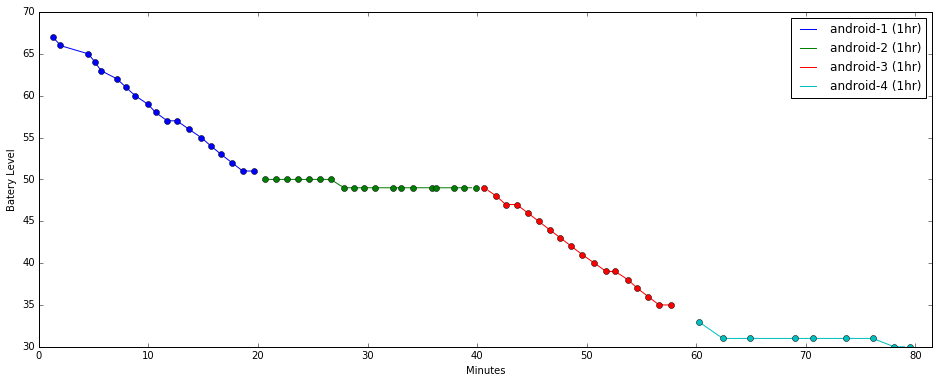

In [17]:
#Android: With interplation on battery data 

(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

#ifig.suptitle(title + ' (Android_overlaid)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    df['hr'] = (df.ts-start_ts0)/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='m', y='battery_level_pct', style=style_interp[i], ax=iaxes, label=("android-%s " % (i+1))+'('+label[i]+')', legend=True)

    
for i, df in enumerate(android_battery_df_list):
    df['hr'] = (df.ts-start_ts0)/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='m', y='battery_level_pct', style=style[i], ax=iaxes, legend=False)
    iaxes.set_xlabel('Minutes')
    iaxes.set_ylabel('Batery Level')
    #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))


In [18]:
from scipy import stats

label=['video1', 'standby1', 'video2', 'standby2']
slope_list=[]
print "From linear model fitting ..." 
for i, df in enumerate(android_battery_interp_df_list):
    notnull = df.battery_level_pct.notnull()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.m[notnull], df.battery_level_pct[notnull])
    print label[i]  + ": slope="+str(slope) + " %/hr  std_err="+str(std_err)
    slope_list.append(slope)

ratio = (slope_list[0]+slope_list[2])/(slope_list[1]+slope_list[3])
print "\nsw ratio of video/standby=" + str(ratio)

From linear model fitting ...
video1: slope=-0.91721828951 %/hr  std_err=0.0100110054058
standby1: slope=-0.070930621362 %/hr  std_err=0.00762407794291
video2: slope=-0.867265647271 %/hr  std_err=0.00937740127723
standby2: slope=-0.0640020834921 %/hr  std_err=0.0104684226504

sw ratio of video/standby=13.2249919596


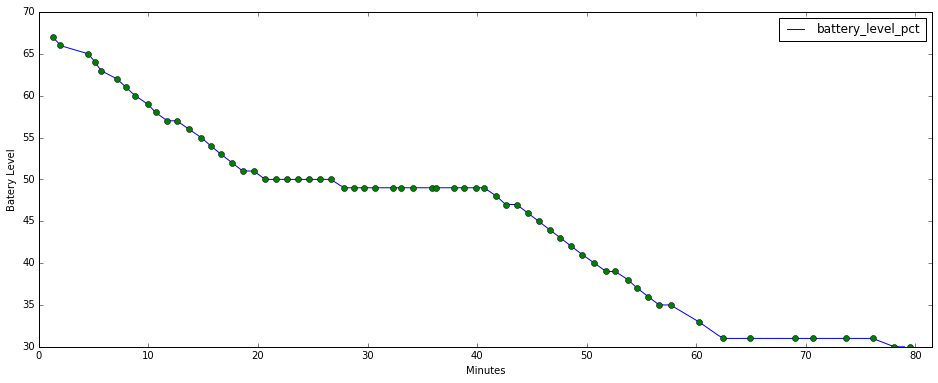

In [19]:
#Android: With interplation on battery data 

(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

#ifig.suptitle(title + ' (Android_overlaid)', fontsize=14, fontweight='bold')

#'''
#for i, df in enumerate(android_battery_interp_df_list):
df = android_battery_interp_df
df['hr'] = (df.ts-start_ts)/3600.0
df['m'] = df.hr*60.0
df.plot(x='m', y='battery_level_pct', ax=iaxes, legend=True)
#'''

#'''
#for i, df in enumerate(android_battery_df_list):
df = android_battery_df
df['hr'] = (df.ts-start_ts)/3600.0
df['m'] = df.hr*60.0
df.plot(x='m', y='battery_level_pct', style='o', ax=iaxes, legend=False)
iaxes.set_xlabel('Minutes')
iaxes.set_ylabel('Batery Level')
#plt.xticks(np.arange(min(df.dt), max(df.dt), 1))
#'''
